In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords

# Download stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load dataset (replace with your path if needed)
df = pd.read_csv("Reviews.csv" )  # From the Amazon Fine Food Reviews dataset on Kaggle

# View structure
print(df[['Score', 'Text']].head())



   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


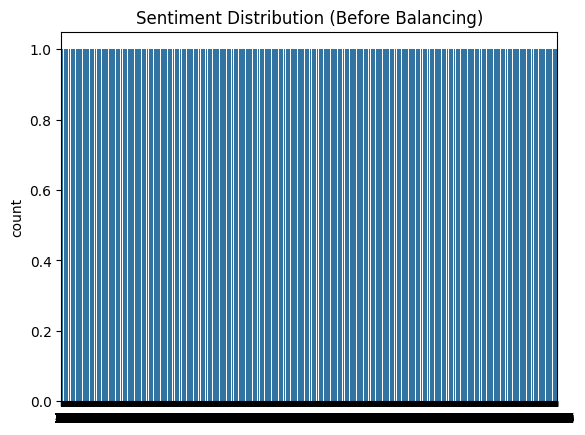

In [3]:
# Load only 10k reviews to reduce processing time
df = pd.read_csv("Reviews.csv", nrows=10000)

# Continue as before
df = df[['Score', 'Text']].dropna()
df = df[df['Score'] != 3]
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Optional: Confirm it worked
sns.countplot(df['Sentiment'])
plt.title("Sentiment Distribution (Before Balancing)")
plt.show()


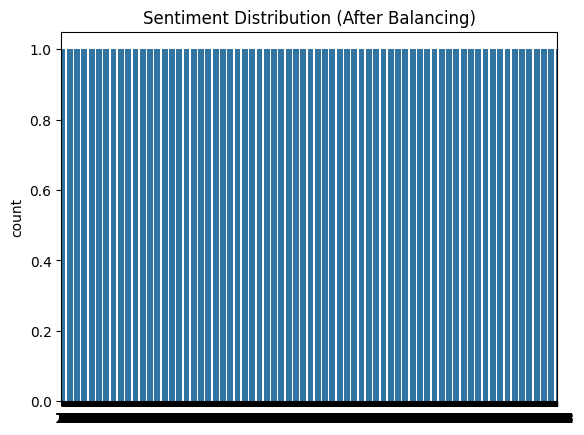

In [6]:
# Separate positive and negative classes
pos = df[df['Sentiment'] == 1]
neg = df[df['Sentiment'] == 0]

# Downsample to the smaller class size
min_len = min(len(pos), len(neg))
df_balanced = pd.concat([
    pos.sample(min_len, random_state=42),
    neg.sample(min_len, random_state=42)
])

# Shuffle and reset index
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Final class distribution check
sns.countplot(df_balanced['Sentiment'])
plt.title("Sentiment Distribution (After Balancing)")
plt.show()


In [7]:
def clean_text(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r'\d+', '', text)                    # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # Remove extra whitespace
    words = text.split()
    words = [w for w in words if w not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply cleaning function
df_balanced['CleanText'] = df_balanced['Text'].apply(clean_text)

# Preview
print(df_balanced[['Text', 'CleanText', 'Sentiment']].sample(5))


                                                   Text  \
409   Love this product.  Very flavorable to most an...   
1534  Becareful if you plan to use these more then t...   
842   The product is a good value for the amount you...   
824   I am very happy with this tea.  I hesitated to...   
1421  These chips are nasty.  I thought someone had ...   

                                              CleanText  Sentiment  
409   love product flavorable anything works great l...          1  
1534  becareful plan use two months order expire qui...          0  
842   product good value amount get however way salt...          0  
824   happy tea hesitated order price comes nice tin...          1  
1421  chips nasty thought someone spilled drink bag ...          0  


In [8]:
# Count real missing values (np.nan, None)
print("Real missing values (NaN or None):")
print(df['Text'].isnull().sum())

# Count empty strings
print("\nEmpty strings:")
print((df['Text'] == '').sum())

# Count string "NaN"
print('\nString "NaN":')
print((df['Text'] == 'NaN').sum())

# View sample rows that match any of these
print("\nSample problematic rows:")
problematic = df[df['Text'].isin(['', 'NaN']) | df['Text'].isnull()]
print(problematic.head())


Real missing values (NaN or None):
0

Empty strings:
0

String "NaN":
0

Sample problematic rows:
Empty DataFrame
Columns: [Score, Text, Sentiment]
Index: []


In [9]:
import numpy as np

# Replace "" and "NaN" string with actual np.nan
df['Text'].replace(["", "NaN"], np.nan, inplace=True)

# Now safely drop all rows where 'Text' is missing
df.dropna(subset=['Text'], inplace=True)


/tmp/ipython-input-168136813.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Text'].replace(["", "NaN"], np.nan, inplace=True)


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load your Amazon Reviews dataset
# If already loaded earlier, just skip this and use your variable
df = pd.read_csv('Reviews.csv')

# Step 2: Basic cleaning
df.dropna(subset=['Text', 'Score'], inplace=True)
df.drop_duplicates(subset='Text', inplace=True)

# Step 3: Map ratings to sentiment
def get_sentiment(Score):
    if Score <= 2:
        return 0  # Negative
    elif Score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['Score'].apply(get_sentiment)

# Step 4: Train-test split
X = df['Text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Step 5: Convert text into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 6: Train Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=200)

              precision    recall  f1-score   support

    Negative       0.72      0.64      0.68     11413
     Neutral       0.47      0.13      0.20      5951
    Positive       0.89      0.97      0.93     61352

    accuracy                           0.86     78716
   macro avg       0.69      0.58      0.60     78716
weighted avg       0.83      0.86      0.84     78716



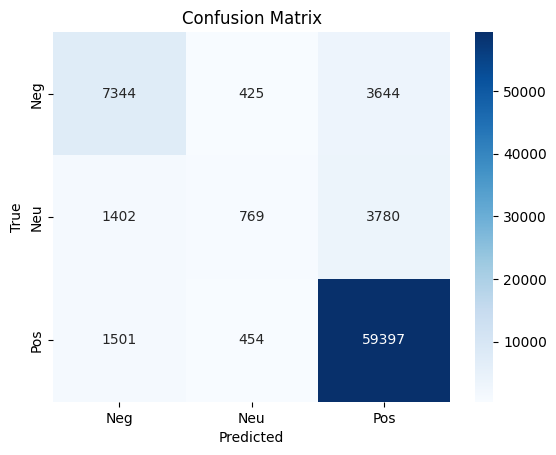

In [14]:
# Predict on test set
y_pred = model.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Show some actual predictions
for i in range(5):
    print(f"\nReview: {X_test.iloc[i][:300]}...")
    print(f"True Sentiment: {y_test.iloc[i]}, Predicted: {y_pred[i]}")



Review: This is basically a black tea with cinnamon. I cannot taste any raspberry, which is probably right because they are not even listed in the ingredients, unless you count "natural flavors".  I would recommend passing on this if you hope to enjoy a raspberry tea. I would recommend passing on this in ge...
True Sentiment: 0, Predicted: 0

Review: I wasted $27.89 in an attempt to keep squirrels and chipmunks away. They are still in yard following application.  Save you money, do not purchase this product....
True Sentiment: 0, Predicted: 0

Review: I originally started buying Zevia a year ago for my diabetic mother - we actually did some glucose testing just after drinking a can and our glucose levels did not change so that was good to know. The flavors are good, especially Dr. Zevia. I recently was able to but the new flavors in Chicago (crea...
True Sentiment: 2, Predicted: 2

Review: I use these at work, for the too many occasions when I do not have time for a real lunch....
Tru